In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq

The quote is from Elf: "I'm sorry I ruined your lives and crammed 11 cookies into the VCR"

In [2]:
from scipy.io import wavfile

file_path = './elf_quote.wav'
sample_rate, audio_data = wavfile.read(file_path)

print("Sample rate:", sample_rate)
print("Audio data shape:", audio_data.shape)

Sample rate: 16000
Audio data shape: (124992,)


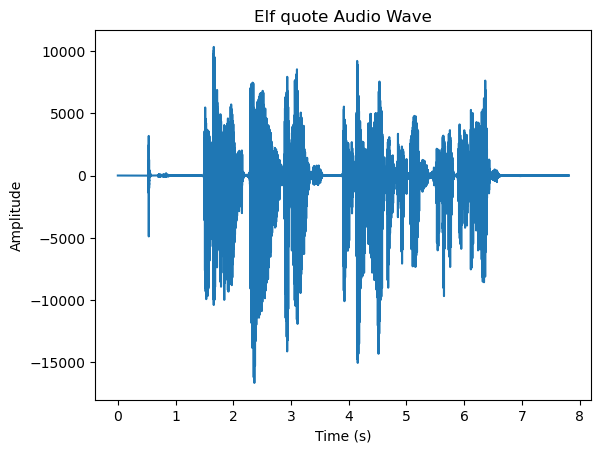

In [238]:
duration = len(audio_data) / sample_rate
audio_time = np.linspace(0, duration, len(audio_data))

plt.plot(audio_time, audio_data)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Elf quote Audio Wave")
plt.savefig("./elf_quote_audio_wave.png")

/Users/matthewkeller/anaconda3/envs/bme-252-final/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'FFT of Elf quote Audio Wave')

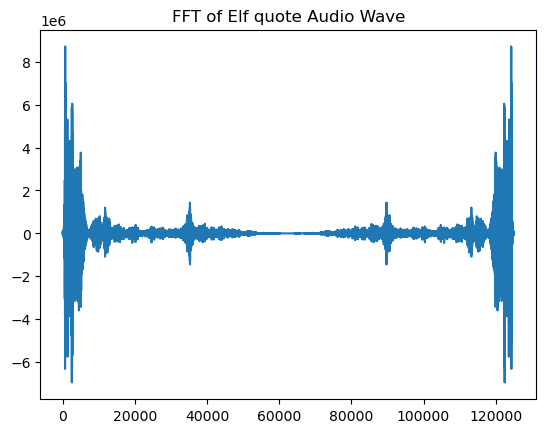

In [100]:
fft_signal = fft(audio_data)
plt.plot(fft_signal)
plt.title("FFT of Elf quote Audio Wave")

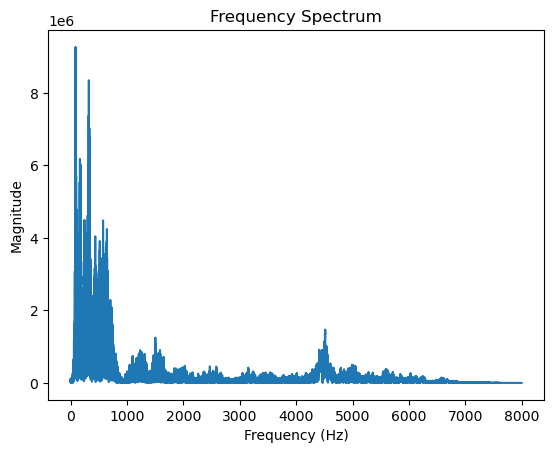

In [102]:
SAMPLING_RATE = 16e3
fft_result = np.fft.fft(audio_data)
frequencies = np.fft.fftfreq(len(fft_result), d=1.0/SAMPLING_RATE)
positive_frequencies = frequencies[:len(frequencies)//2]
magnitude_spectrum = np.abs(fft_result[:len(fft_result)//2])

plt.plot(positive_frequencies, magnitude_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum')
plt.show()


In [4]:
# Need to test different chunk sizes
# Need to test if there are overlaps

chunk_length = [50, 100, 200,]
overlaps = [0, 20,]

# split up audio into chunks
def split_audio(audio_data, chunk_length, overlap):
    assert overlap < chunk_length, "Overlap must be less than chunk length"
    chunks = []
    start = 0
    length_of_audio = len(audio_data)
    while start < length_of_audio:
        end = start + chunk_length
        if end > len(audio_data):
            chunk = audio_data[start:length_of_audio]
        else:
            chunk = audio_data[start:end]
        chunks.append(chunk)
        start += chunk_length - overlap
    return chunks
    
chunks_for_overlap = np.zeros((len(chunk_length), len(overlaps)), dtype=object)
for chunk_index, chunk_length in enumerate(chunk_length):
    for overlap_index, overlap in enumerate(overlaps):
        chunks = split_audio(audio_data, chunk_length=chunk_length, overlap=overlap)
        chunks_for_overlap[chunk_index][overlap_index] = chunks

In [221]:
# TEST BASE PARAMETERS
CHUNK_LENGTH = 10
OVERLAP = 0
CENTRE_FREQUENCY = 50
TYPE = "butterworth"
BAND_WIDTH = 45
ORDER = 5
NUMBER_OF_FILTERS=20

def create_bandpass_filters(centre_frequency, band_width, filter_type, number_of_filters, order, sample_rate = 16000):
    filters = [create_bandpass_filter(filter_type=filter_type, order=order, centre_freq=centre_frequency + 100*i, band_width=band_width, sample_rate=sample_rate) for i in range(number_of_filters)]
    return filters

def create_bandpass_filter(filter_type: str, order: int, centre_freq: int, band_width: int, sample_rate: int):
        if filter_type == "butterworth":
            return signal.butter(
                order, 
                [centre_freq - band_width, centre_freq + band_width], 
                btype='bandpass', 
                output='sos', 
                fs=sample_rate
            )
        elif filter_type == "chebyshev":
            return signal.cheby2(
                order, 
                20, 
                [centre_freq - band_width, centre_freq + band_width], 
                btype='bandpass', 
                output='sos', 
                fs=sample_rate
            )
        else:
            raise ValueError("Filter type must be either 'butterworth' or 'chebyshev'")


def filter_chunk(filter, chunk):
    return signal.sosfilt(filter, chunk)

def get_rms(filtered_chunk):
    return np.mean(np.sqrt(filtered_chunk**2))
    # return np.mean(np.square(filter_chunk(filter=filter, chunk=chunk)))    

def synthesize(rms, chunk_length, centre_freq_band):
    time = np.arange(chunk_length)
    varying_amplitude = rms * np.sin(2 * np.pi * centre_freq_band * time)
    return varying_amplitude

In [222]:
test_filters = create_bandpass_filters(centre_frequency=CENTRE_FREQUENCY, band_width=BAND_WIDTH, filter_type=TYPE, number_of_filters=NUMBER_OF_FILTERS, order=ORDER)

In [223]:
test_chunks = chunks_for_overlap[1][1]

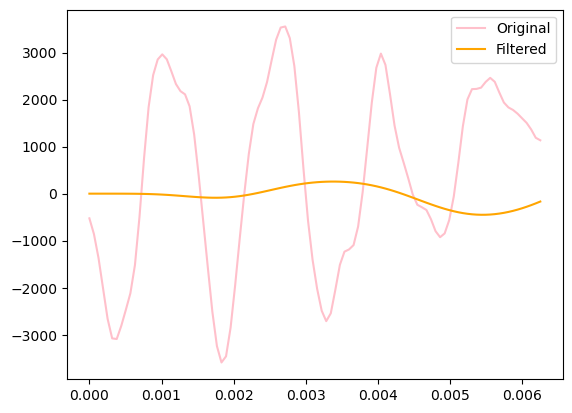

In [224]:
test_chunk = test_chunks[300]

filter = create_bandpass_filter(filter_type=TYPE, order=ORDER, centre_freq=200, band_width=100, sample_rate=sample_rate)
test_fit = signal.sosfilt(filter, test_chunk)
plt.plot(np.linspace(0, len(test_chunk)/16000, len(test_chunk)), test_chunk, color="pink", label="Original")
plt.plot(np.linspace(0, len(test_chunk)/16000, len(test_chunk)), test_fit, color="orange", label="Filtered")
plt.legend()
plt.show()


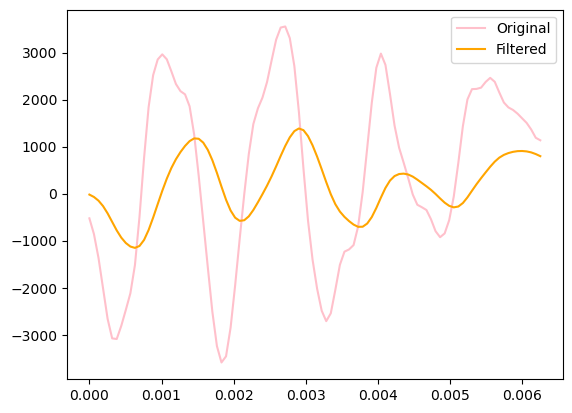

In [225]:
test_chunk = test_chunks[300]
sos = signal.butter(
                1, 
                # [CENTRE_FREQUENCY - BAND_WIDTH/2, CENTRE_FREQUENCY + BAND_WIDTH/2], 
                [200 - 100, 200 + 100], 
                btype='bandpass', 
                output='sos', 
                fs=16000
            )
filtered_test_chunk = signal.sosfilt(sos, test_chunk)
plt.plot(np.linspace(0, len(test_chunk)/16000, len(test_chunk)), test_chunk, color="pink", label="Original")
plt.plot(np.linspace(0, len(test_chunk)/16000, len(test_chunk)), filtered_test_chunk, color="orange", label="Filtered")
plt.legend()
plt.show()

In [226]:
filters = create_bandpass_filters(centre_frequency=CENTRE_FREQUENCY, band_width=BAND_WIDTH, filter_type=TYPE, number_of_filters=NUMBER_OF_FILTERS, order=ORDER)

def concat_chunks(chunks):
    return np.concatenate(chunks)
    


In [227]:
synth_chunks = []
for filter in filters:
    chunks_for_filter = []
    for chunk in test_chunks:
        filtered_chunk = filter_chunk(filter=filter, chunk=test_chunk)
        rms = get_rms(filtered_chunk=filtered_chunk)
        synth_chunk = synthesize(rms=rms, chunk_length=len(test_chunk), centre_freq_band=200)
        chunks_for_filter.append(synth_chunk)
    synth_chunks.append(chunks_for_filter)


In [228]:
len(synth_chunks[0][0])

100

In [229]:
concatenated_chunks = [concat_chunks(chunks) for chunks in synth_chunks]

In [230]:
len(concatenated_chunks[0])

156300

In [232]:
concatenated_chunks[0]

array([ 0.00000000e+00,  2.49204160e-13,  4.98408319e-13, ...,
       -1.70530021e-10, -1.34224738e-10, -9.79194554e-11])

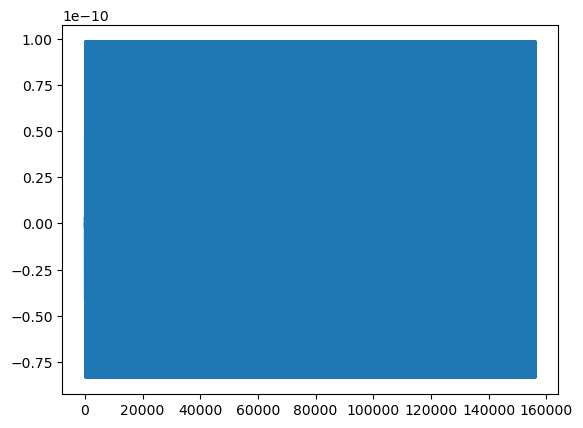

In [233]:
plt.plot(concatenated_chunks[1])

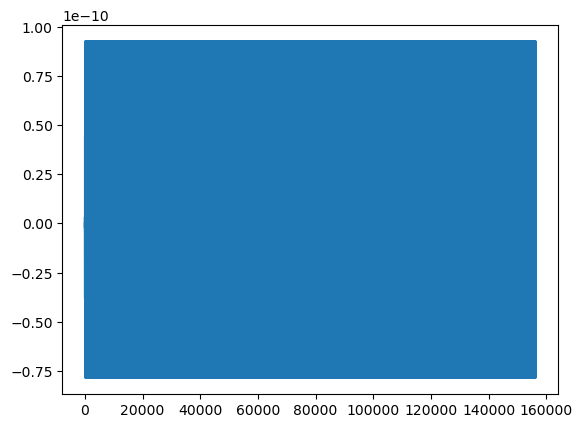

In [234]:
plt.plot(concatenated_chunks[2])

In [235]:
summed_chunks = np.sum(concatenated_chunks, axis=0)

In [236]:
len(summed_chunks)

156300

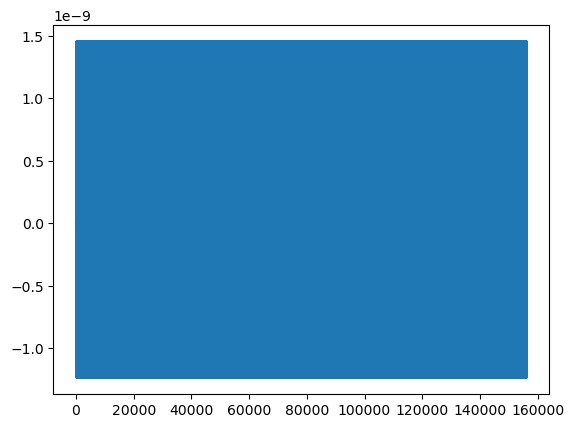

In [237]:
plt.plot(summed_chunks)

In [218]:
# save summed chunks to a wav file as if this were a voice signal sampled at 16kHz
import wave
output_file_test = "./output_test.wav"
sample_rate = 16e3
num_channels = 1
bytes_per_sample = 2 # 16 bit audio
num_frames = len(summed_chunks)


with wave.open(output_file_test, 'w') as output_file:
    output_file.setparams((num_channels, bytes_per_sample, sample_rate, num_frames, "NONE", "Uncompressed"))
    output_file.writeframes(summed_chunks.astype(np.int16).tobytes())

In [7]:
# centre_freqs = [100, 200,]
# types = ["butterworth", "chebyshev",]
# orders = [2, 4]
# number_of_filters = [3, 5]
# band_widths = [10, 20]

# test_chunks = chunks_for_overlap[2][0]
# len(test_chunks)

# filtered_chunk_groups = np.zeros((len(centre_freqs), len(types), len(orders), len(number_of_filters), len(band_widths)), dtype=object)

# for centre_freq_index, centre_freq in enumerate(centre_freqs):
#     for filter_type_index, filter_type in enumerate(types):
#         for order_index, order in enumerate(orders):
#             for number_of_filters_index, number_of_filter in enumerate(number_of_filters):
#                 for band_width_index, band_width in enumerate(band_widths):
#                     filters = []
#                     # print(centre_freq, filter_type, order, number_of_filter, band_width)
#                     for i in range(number_of_filter):
#                         if filter_type == "butterworth":
#                             sos = signal.butter(
#                                 order, 
#                                 [centre_freq - band_width, centre_freq + band_width], 
#                                 btype='bandpass', 
#                                 output='sos', 
#                                 fs=sample_rate
#                             )
#                         elif filter_type == "chebyshev":
#                             sos = signal.cheby2(
#                                 order, 
#                                 20, 
#                                 [centre_freq - band_width, centre_freq + band_width], 
#                                 btype='bandpass', 
#                                 output='sos', 
#                                 fs=sample_rate
#                             )
#                         filters.append(sos)
                
#                     # Filter all the chunks and save to new list
                    
#                     filter_chunks = []
#                     for filter in filters:
#                         filtered_chunks = []
#                         for chunk in test_chunks:
#                             chunk = signal.sosfilt(filter, chunk)
#                             filtered_chunks.append(chunk)
#                         filter_chunks.append(filtered_chunks)
                    
#                     filtered_chunk_groups[centre_freq_index][filter_type_index][order_index][number_of_filters_index][band_width_index] = filter_chunks
                    
# filtered_chunk_groups